## Dataset 1 : AirBnB Open Data from Seattle
###### Problem to solve is Regression
********

## Converting all 3 csv files to dataframes

In [109]:
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes
import matplotlib.pyplot as plt
import seaborn as sb
from wordcloud import WordCloud, ImageColorGenerator
from langdetect import detect

nltk.download('vader_lexicon')
sb.set()
pd.set_option('display.max_columns', 500)   
# pd.set_option('display.max_rows', 500)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/caeden/nltk_data...


In [112]:
calendar = pd.read_csv('seattle/calendar.csv')
listings = pd.read_csv('seattle/listings.csv')
reviews = pd.read_csv('seattle/reviews.csv')

In [115]:
calendar.head()

listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN
3      241032  2016-01-07         f     NaN
4      241032  2016-01-08         f     NaN

In [ ]:
listings.head()

In [120]:
reviews.head()

listing_id        id        date  reviewer_id reviewer_name  \
0     7202016  38917982  2015-07-19     28943674        Bianca   
1     7202016  39087409  2015-07-20     32440555         Frank   
2     7202016  39820030  2015-07-26     37722850           Ian   
3     7202016  40813543  2015-08-02     33671805        George   
4     7202016  41986501  2015-08-10     34959538          Ming   

                                            comments  
0  Cute and cozy place. Perfect location to every...  
1  Kelly has a great room in a very central locat...  
2  Very spacious apartment, and in a great neighb...  
3  Close to Seattle Center and all it has to offe...  
4  Kelly was a great host and very accommodating ...

# Cleaning up data 
* Removing all dollar signs
* Converting date to date time 
* Tabulating the number of nulls in the dataset



In [123]:
# Calendar df
calendar.price = calendar.price.replace('[\$,]', '', regex=True).astype(float)
calendar.date = pd.to_datetime(calendar.date)

# Listings df
listings.price = listings.price.replace('[\$,]', '', regex=True).astype(float)
listings.weekly_price = listings.weekly_price.replace('[\$,]', '', regex=True).astype(float)
listings.monthly_price = listings.monthly_price.replace('[\$,]', '', regex=True).astype(float)
listings.extra_people = listings.extra_people.replace('[\$,]', '', regex=True).astype(float)
listings.cleaning_fee = listings.cleaning_fee.replace('[\$,]', '', regex=True).astype(float)
listings.security_deposit = listings.security_deposit.replace('[\$,]', '', regex=True).astype(float)
listings.host_acceptance_rate = listings.host_acceptance_rate.astype(str).str.replace('%','').astype(float)
listings.host_response_rate = listings.host_response_rate.astype(str).str.replace('%','').astype(float)
listings.host_since = pd.to_datetime(listings.host_since)

# reviews df
reviews.date = pd.to_datetime(reviews.date)


In [126]:
# count the number of Null in each column for listing dataframe
listings.isnull().sum().to_frame(name='counts').query('counts > 0').sort_values(by=['counts'],ascending=False)

counts
license                        3818
square_feet                    3721
monthly_price                  2301
security_deposit               1952
weekly_price                   1809
notes                          1606
neighborhood_overview          1032
cleaning_fee                   1030
transit                         934
host_about                      859
host_acceptance_rate            773
review_scores_accuracy          658
review_scores_checkin           658
review_scores_value             656
review_scores_location          655
review_scores_cleanliness       653
review_scores_communication     651
review_scores_rating            647
last_review                     627
first_review                    627
reviews_per_month               627
space                           569
host_response_rate              523
host_response_time              523
neighbourhood                   416
xl_picture_url                  320
medium_url                      320
thumbnail_url                   320
host_neighbourhood              300
summary                         177
bathrooms                        16
host_location                     8
zipcode                           7
bedrooms                          6
host_has_profile_pic              2
host_total_listings_count         2
host_listings_count               2
host_picture_url                  2
host_thumbnail_url                2
host_is_superhost                 2
host_since                        2
host_name                         2
host_identity_verified            2
beds                              1
property_type                     1

In [129]:
# count the number of Null in each column for reviews dataframe
reviews.isnull().sum().to_frame(name='counts').query('counts > 0').sort_values(by=['counts'],ascending=False)

counts
comments      18

In [132]:
# count the number of Null in each column for calendar dataframe
calendar.isnull().sum().to_frame(name='counts').query('counts > 0').sort_values(by=['counts'],ascending=False)

counts
price  459028

# Basic Data Visualisation / Data Analysis
1. Using GeoPandas to visualise the location of the Airbnb around Seattle
2. Bar Graph to show number of airbnb per neighbourhood & avg price per neighbourhood
3. Graph to show how price / number of bookings fluctuate throughout the year
4. Visualisation of the number of ammenities that a listing can have 
5. Graph to show how price differ for different property type / apartment type
6. Sentiment analysis of airbnb reviews
7. Graph of number of listings from 2008 - 2015
-------------------

# 1. Using GeoPandas to visualise the location of the Airbnb around Seattle
Can comment this out because it is extremely slow

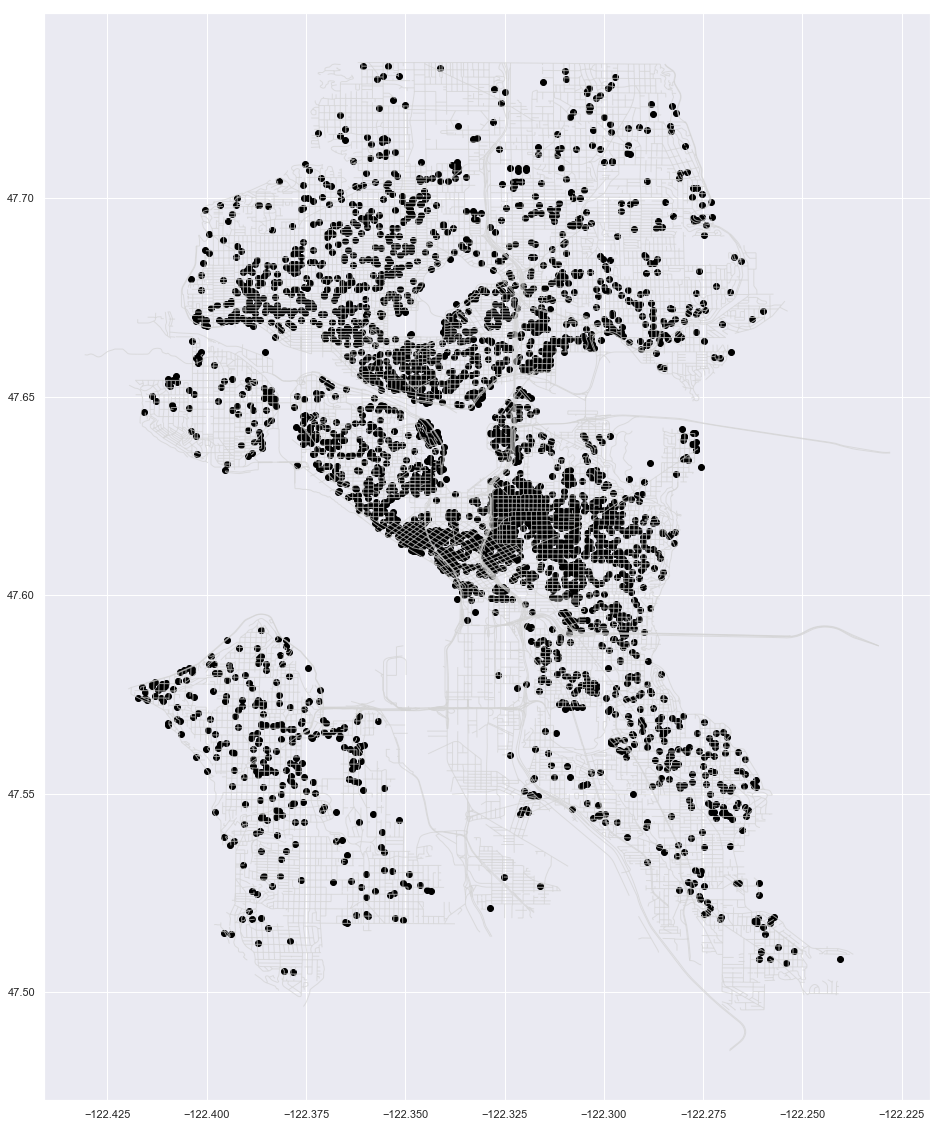

In [135]:
# create a geo panda dataframe  
listings_duplicate = listings.copy()
# change combined _listings to listings_duplicate 
gdf = gpd.GeoDataFrame(listings_duplicate,geometry=gpd.points_from_xy(listings_duplicate['longitude'],listings_duplicate['latitude']))
# reading seattle's street/map data
df_seattle = gpd.read_file('https://opendata.arcgis.com/datasets/383027d103f042499693da22d72d10e3_0.geojson')

fig,ax = plt.subplots(figsize=(30,20))    
# plotting seattle's street/map
df_seattle.plot(color='lightgrey',linewidth=1,alpha=0.7,ax=ax)
# plotting the location of the airbnbs
gdf.plot(color='black',ax=ax)

Most of the airbnbs are clustered in the middle of Seattle

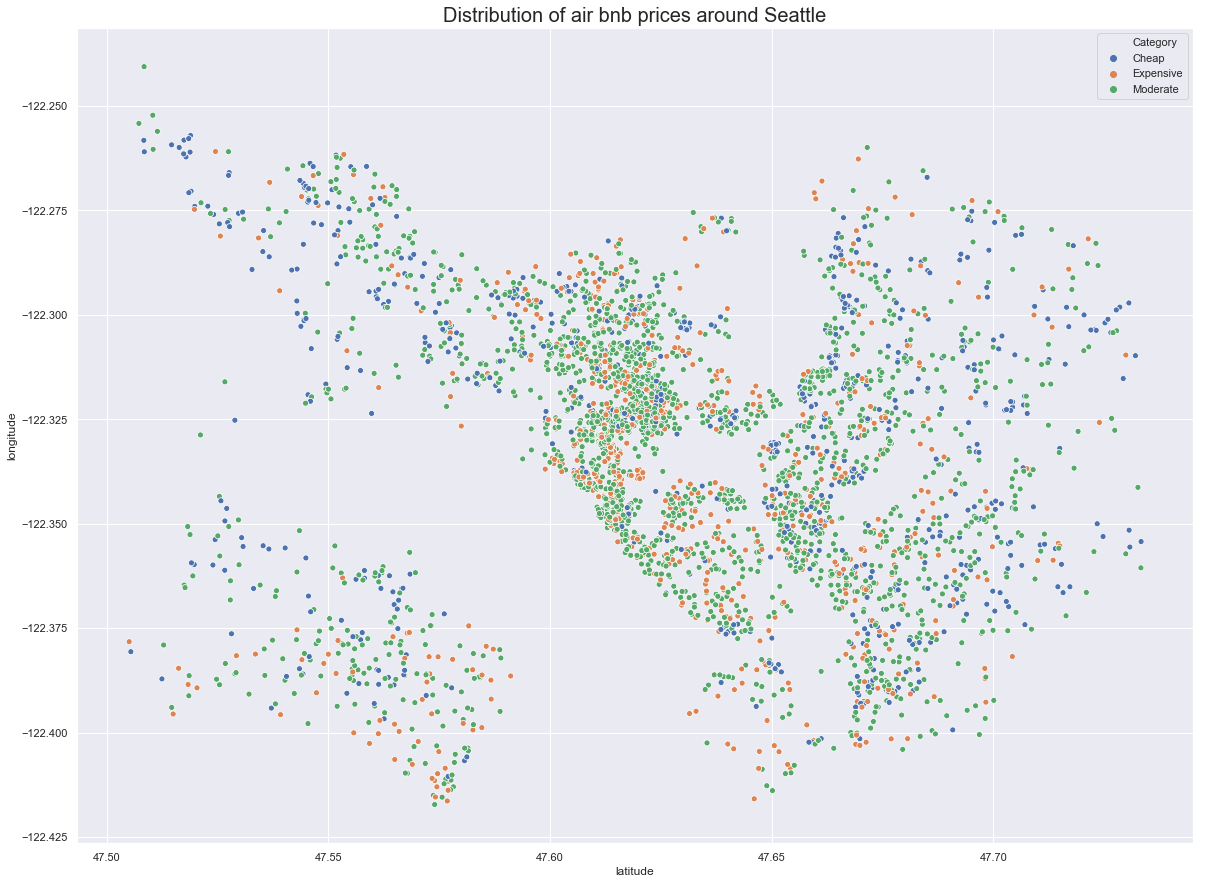

In [138]:
quartile_80 = listings_duplicate['price'].quantile(0.8)
quartile_20 = listings_duplicate['price'].quantile(0.2)

listings_duplicate.loc[listings_duplicate['price'] > quartile_80 , 'Category' ] = 'Expensive' 
listings_duplicate.loc[listings_duplicate['price'] < quartile_20 , 'Category' ] = 'Cheap' 
listings_duplicate.loc[(listings_duplicate['price'] > quartile_20 ) & (listings_duplicate['price'] < quartile_80), 'Category' ] = 'Moderate' 
listings_duplicate['Category'] = listings_duplicate['Category'].astype('category')


fig,ax = plt.subplots(figsize=(20,15))
plt.title('Distribution of air bnb prices around Seattle', fontsize=20)
sb.scatterplot(x="latitude", y="longitude", hue="Category",data=listings_duplicate)

# 2. Number of AirBnb per neighbourhood

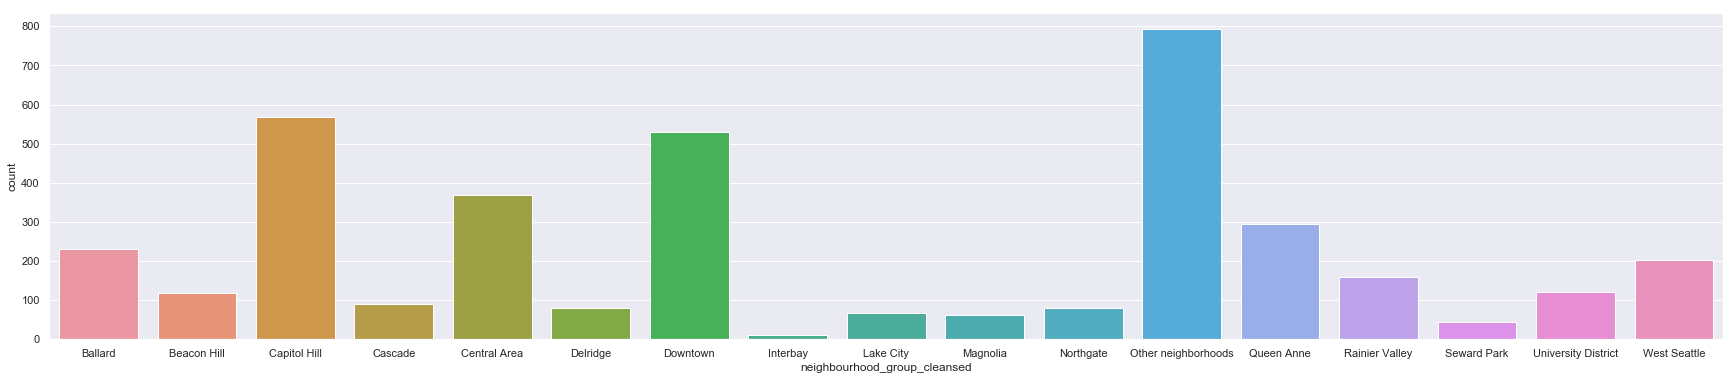

In [141]:
plt.figure(figsize=(30, 6))
sb.countplot(listings["neighbourhood_group_cleansed"])

# 3. Average Price per neighbourhood

In [144]:



listings.neighbourhood_group_cleansed=listings.neighbourhood_group_cleansed.astype('category')


# Plot the price distribution for different neighbourhoods
listings_filtered = pd.DataFrame(listings[["price", "neighbourhood_group_cleansed"]])
price_distribution=pd.pivot_table(listings_filtered,
                                  values = ['price'],
                                  index=['neighbourhood_group_cleansed'] ,
                                  aggfunc = {'price':np.mean})
# count distribution
count_distribution=listings_filtered.groupby('neighbourhood_group_cleansed').count().rename(columns = {'price':'Number of Listings'})

# merge both dataframe together
count_distribution.reset_index()
price_distribution.reset_index()
price_and_count_distribution=count_distribution.merge(price_distribution,left_on='neighbourhood_group_cleansed',right_on='neighbourhood_group_cleansed')
price_and_count_distribution.rename(columns ={'price':'Average Price/day'}).sort_values(by=['Average Price/day'],ascending=False)

Number of Listings  Average Price/day
neighbourhood_group_cleansed                                       
Magnolia                                      61         177.672131
Queen Anne                                   295         157.223729
Downtown                                     530         154.405660
West Seattle                                 203         141.359606
Cascade                                       89         140.101124
Capitol Hill                                 567         130.592593
Central Area                                 369         128.338753
Ballard                                      230         124.682609
Other neighborhoods                          794         119.968514
Interbay                                      11         109.727273
Seward Park                                   44         108.477273
Beacon Hill                                  118          94.669492
University District                          122          93.639344
Lake City                                     67          92.671642
Rainier Valley                               159          91.899371
Northgate                                     80          88.550000
Delridge                                      79          83.278481

# 4 . Visualisation of the number of ammenities that a listing can have

In [147]:
listings['no_of_amenities']= listings.apply(lambda row : len(row.amenities.split(',')) ,axis=1)
listings[['amenities','no_of_amenities']].head()

amenities  no_of_amenities
0  {TV,"Cable TV",Internet,"Wireless Internet","A...               10
1  {TV,Internet,"Wireless Internet",Kitchen,"Free...               16
2  {TV,"Cable TV",Internet,"Wireless Internet","A...               21
3  {Internet,"Wireless Internet",Kitchen,"Indoor ...               14
4  {TV,"Cable TV",Internet,"Wireless Internet",Ki...               13

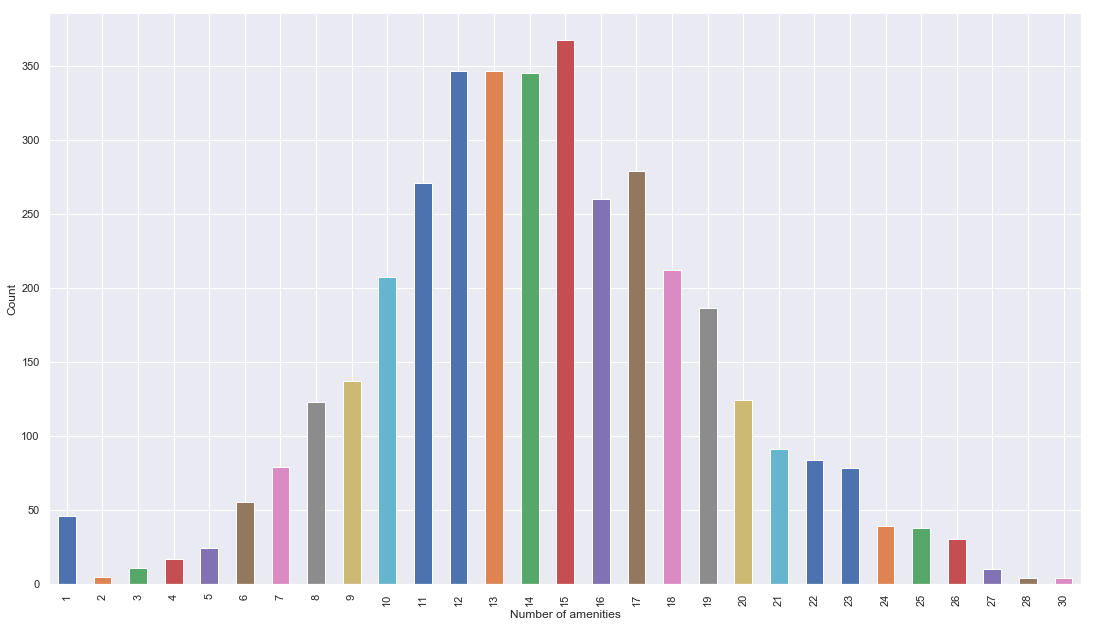

In [150]:
listings['no_of_amenities'].value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Number of amenities')
plt.ylabel('Count')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [153]:
# create a duplicate copy so that we will not affect the original copy
listings_dup = listings[['neighbourhood_group_cleansed','no_of_amenities']].copy()

ammenities_distribution = listings_dup.groupby('neighbourhood_group_cleansed').agg({'no_of_amenities':'mean'}).reset_index()

#merging price_and_count_distribution & ammenities_distribution 
price_and_count_distribution.reset_index()
combined_distribution=ammenities_distribution.merge(price_and_count_distribution,left_on='neighbourhood_group_cleansed',right_on='neighbourhood_group_cleansed')
combined_distribution.head()

neighbourhood_group_cleansed  no_of_amenities  Number of Listings  \
0                      Ballard        13.821739                 230   
1                  Beacon Hill        13.898305                 118   
2                 Capitol Hill        13.007055                 567   
3                      Cascade        13.966292                  89   
4                 Central Area        13.878049                 369   

        price  
0  124.682609  
1   94.669492  
2  130.592593  
3  140.101124  
4  128.338753

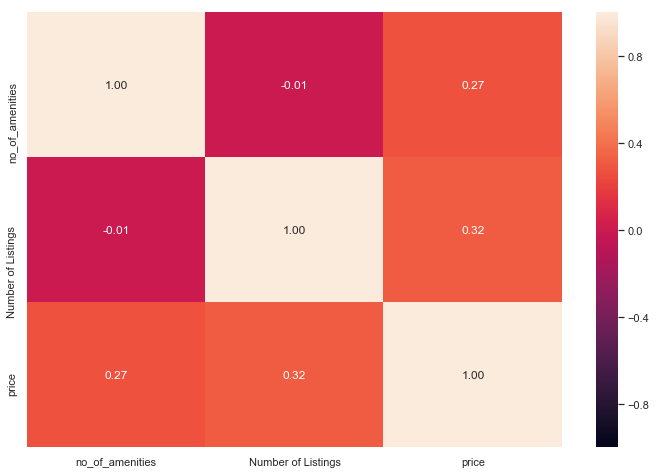

In [156]:
plt.figure(figsize = (12,8))
sb.heatmap(combined_distribution.corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

There seems to be correlation between price , number of amenities and number of listings

# 5. Graph to show how  price & booking fluctuate throughout the year
1)Graph for **average price** against **time**

2)Graph for **number of bookings** against **time**

In [ ]:
# from pandas.tseries import converter
# converter.register()

# Graph for average price against time
calendar_filtered1 = calendar.dropna()
# only consider 2016 data
calendar_filtered1=calendar_filtered1[calendar_filtered1['date'].dt.year==int(2016)]
calendar_filtered1=calendar_filtered1.drop('listing_id',axis=1).groupby(['date']).mean()
calendar_filtered1.reset_index(inplace=True)
# calendar_filtered1['date'] = pd.to_datetime(calendar_filtered1['date'])

plt.figure(figsize=(12,6))
plt.title('Graph for average price against time')
plt.plot(calendar_filtered1['date'], calendar_filtered1['price'])


# Graph for number of bookings against time
# assumption remove available = f from calculation
calendar_filtered2 = calendar.dropna()
# only consider 2016 data
calendar_filtered2=calendar_filtered2[calendar_filtered2['date'].dt.year==int(2016)]
calendar_filtered2=calendar_filtered2.groupby(['date']).size().reset_index(name='counts')
calendar_filtered2['date'] = pd.to_datetime(calendar_filtered2['date'])


plt.figure(figsize=(12,6))
plt.title('Graph for number of bookings against time')
plt.plot(calendar_filtered2['date'], calendar_filtered2['counts'])



The number of booking peaks towards the end of the year as well as during April, to maximise profits the host should raise prices during this 2 period

# 6. Graph to show how price differ for different property / apartment type

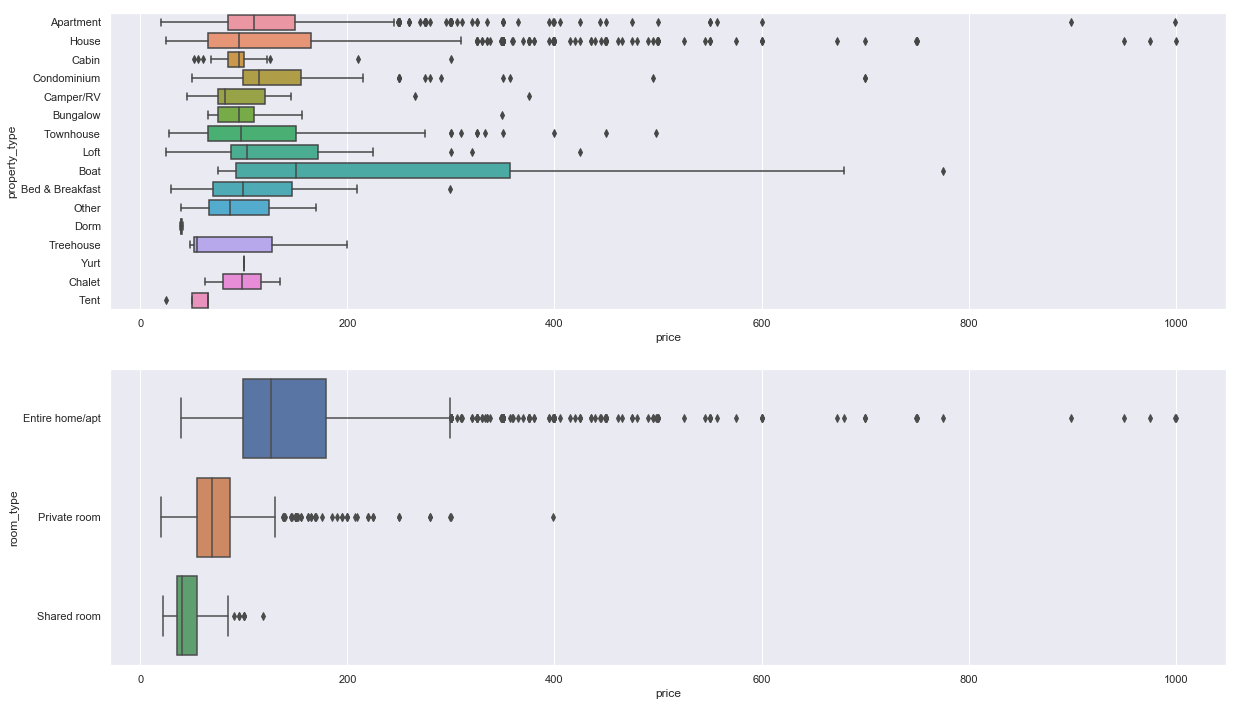

In [161]:
f, axes = plt.subplots(2, 1, figsize=(20,12))
sb.boxplot(x = listings.price , y = listings.property_type , data = listings , orient = "h" , ax = axes[0])
sb.boxplot(x = listings.price , y = listings.room_type , data = listings , orient = "h" , ax=axes[1])

* Property Type = Apartment & House have the most outliers
* Room Type = Entire Room has the most outliers and are generally more expensive

# 6. Sentiment analysis of airbnb reviews

In [ ]:
df_comments = reviews[['listing_id', 'comments','id']].copy().rename(columns = {'id':'comment_id'})
df_neighbourhood = listings[['id','neighbourhood_cleansed']]


def getNeighborhood(listing_id):
    neighbourhood = listings.loc[listings['id'] == listing_id, 'neighbourhood_cleansed'].iloc[0]
    return neighbourhood

df_comments.dropna(inplace = True)  #drop all empty rows
df_comments['neighbourhood'] = df_comments['listing_id'].apply(getNeighborhood)
df_comments

In [166]:
def sentiment_analyzer_scores(comment):
    sentence = str(comment)
    score = analyser.polarity_scores(comment)
    return score['compound']

analyser = SentimentIntensityAnalyzer()
df_comments['polarity'] = df_comments['comments'].apply(sentiment_analyzer_scores)
df_comments.sort_values(by=['polarity'],ascending=True,inplace = True)

df_comments.sample(10)

listing_id                                           comments  \
81861      458191  Honestly, I don't have anything negative to sa...   
46552      241032  This space was perfect for our stay in Seattle...   
42647       63733  We had a great stay at the Best Value Ballard ...   
30492     5633607  The place was perfect, as advertised! \r\n\r\n...   
69516     2526405  Chris and Carly were absolutely wonderful host...   
7937      5031285  I ended up canceling my reservation because I ...   
27333     2103939  The host canceled this reservation 15 days bef...   
69523     2526405  It was a pleasure to stay at Chris' place and ...   
22079     3697351  My aunt and I stayed at Jakub's during the beg...   
64849     6424982  Ruth house at a great location! It's like a hi...   

       comment_id           neighbourhood  polarity  
81861    25615766                Broadway    0.9613  
46552    35088919         West Queen Anne    0.9761  
42647      429695           West Woodland    0.9391  
30492    48296787                Broadway    0.9250  
69516    35463663                 Stevens    0.9516  
7937     37102725  International District    0.7210  
27333    42503109            Madison Park    0.0000  
69523    39287581                 Stevens    0.9612  
22079    23761266                Belltown    0.9580  
64849    58231179         West Queen Anne    0.9622

Due to certain limitation in the SentimentIntensityAnalyzer library , reviews writen in foreign languages tend to have a lower polarity score.

In [ ]:
# A histogram of the polarity scores (to show the spread of polarity scores)
num_bins = 50
plt.figure(figsize=(18,8))
n, bins, patches = plt.hist(df_comments.polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of polarity score')
plt.show()

In [171]:
print('The mean polarity score is = ' + str(df_comments.polarity.describe().iloc[1]))
print('The median polarity score is = ' + str(df_comments.polarity.describe().iloc[5]))

The mean polarity score is = 0.8849848817059635
The median polarity score is = 0.9541


Most reviews have a positive score , with a significant number close to 1.

In [173]:
polarity_per_listing_id=df_comments.groupby('listing_id',as_index=False)['polarity'].mean()
polarity_per_listing_id.sort_values(by=['polarity'],ascending=True,inplace = True)
polarity_per_listing_id.sample(5)

listing_id  polarity
2492     7678064    0.9274
937      3279728    0.7548
1275     4243163    0.6433
1087     3766285    0.1706
1689     5639238    0.9286

In [175]:
print('Positive scores: ',polarity_per_listing_id['polarity'][polarity_per_listing_id['polarity'] > 0].count())
print('Negative scores: ',polarity_per_listing_id['polarity'][polarity_per_listing_id['polarity'] < 0].count())
print('Neutral scores: ',polarity_per_listing_id['polarity'][polarity_per_listing_id['polarity'] == 0].count())

Positive scores:  3165
Negative scores:  5
Neutral scores:  21


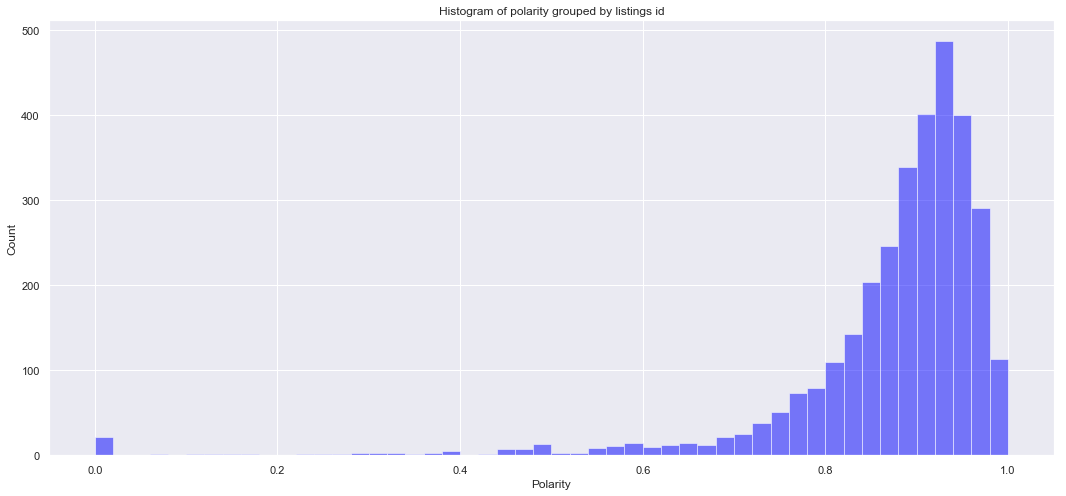

listing_id  polarity
3065     9183838   -0.9863
2867     8474294   -0.9783
475      1343805   -0.4497
2602     7873208   -0.3382
2519     7732071   -0.0467

In [177]:
# A histogram of the polarity scores grouped by listing_id
num_bins = 50
plt.figure(figsize=(18,8))
n, bins, patches = plt.hist(polarity_per_listing_id.polarity, num_bins, facecolor='blue', alpha=0.5, range = [0, 1.0])
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of polarity grouped by listings id')
plt.show()
polarity_per_listing_id.head()

In [179]:
print('The mean polarity score is ' + str(polarity_per_listing_id.polarity.describe().iloc[1]))
print('The median polarity score is ' + str(polarity_per_listing_id.polarity.describe().iloc[5]))

The mean polarity score is 0.8701993312493541
The median polarity score is 0.9046691176470587


When the polarity scores are grouped by listing_id there is a slight left shift in the graph , this implies that there are once in a while there are negative reviews to pull the average polarity score for eact listing_id.

In [181]:


# to improve the speed of the code
# we will scale down the dataframe
df_comments_sample = df_comments.sample(3000)

for index, row in df_comments_sample['comments'].iteritems():
    try:
        lang = detect(row) # detecting each row
        df_comments_sample.loc[index, 'language_used'] = lang
    except:
        df_comments_sample.loc[index, 'language_used'] = 'Error'
        
df_comments_sample.language_used.unique()

array(['en', 'fr', 'es', 'pt', 'it', 'nl', 'af', 'ko', 'ro', 'ja', 'da',
       'de', 'zh-cn', 'zh-tw'], dtype=object)

In [ ]:
df_comments_sample_by_language_count = df_comments_sample.groupby(['language_used']).size().reset_index(name = 'count')
df_comments_sample_by_language_count.sort_values(by = 'count' , ascending = False)

Most reviews are writen in English , there is also a small portion of reviews writen in laguages such as French and Spanish. 

In [184]:
df_comments_sample_average_polarity = pd.DataFrame(df_comments_sample.groupby(['language_used'])['polarity'].mean())
df_comments_sample_average_polarity.sort_values(by = 'polarity' , ascending = False)

polarity
language_used          
en             0.887769
af             0.591150
ro             0.567750
it             0.340000
da             0.273200
fr             0.139289
ja             0.000000
ko             0.000000
nl             0.000000
zh-cn          0.000000
zh-tw          0.000000
es            -0.035067
pt            -0.354400
de            -0.799467

Reviews writen in English tend to have a higher polarity score . Whereas , reviews writen in other laguages tend to have a lower polarity . Futhermore , some languages like zh-cn (Chinese) have a score of 0 .This could be due to certain limitations in the SentimentIntensityAnalyzer library 

In [ ]:
# Cutting the dataframe by half will make the function run faster
filtered_reviews = reviews.sample(40000)
concatenatedReviews = " ".join(str(row) for row in filtered_reviews['comments'])
# # Generate a word cloud image:
wordCloud = WordCloud(max_words=200, background_color="white").generate(concatenatedReviews)

plt.figure(figsize=(10,6))
plt.figure(figsize=(15,10))

plt.imshow(wordCloud, interpolation='Bilinear')
plt.axis("off")
plt.show()


# 7. Graph of number of listings from 2008 - 2015

In [187]:
listings_duplicate["host_since_year"] = listings_duplicate["host_since"].dt.year
listings_duplicate_filtered = listings_duplicate[['host_since','host_since_year']]
listings_duplicate_filtered = listings_duplicate_filtered.groupby(['host_since_year']).size().reset_index(name = 'count')
listings_duplicate_filtered["total listings"] = listings_duplicate_filtered['count'].cumsum()
listings_duplicate_filtered

host_since_year  count  total listings
0           2008.0      4               4
1           2009.0     64              68
2           2010.0    149             217
3           2011.0    398             615
4           2012.0    539            1154
5           2013.0    776            1930
6           2014.0    900            2830
7           2015.0    981            3811
8           2016.0      5            3816

In [ ]:
plt.figure(figsize=(18, 6))
plt.title('Number of Listings')
sb.lineplot(x="host_since_year", y="total listings", data=listings_duplicate_filtered, label="Total Number of listings")
sb.lineplot(x="host_since_year", y="count", data=listings_duplicate_filtered , label="Number of new listings")
plt.xlabel("Year")
plt.ylabel("Number")

# Linear Regression
-----

In [197]:
from sklearn.linear_model import LinearRegression

#### Price's correlation with other variable

In [198]:
filtered_listings = listings.select_dtypes(include =['float64','int64']) 
to_drop = ['id','scrape_id','host_id','latitude','longitude','license']
filtered_listings = filtered_listings.drop(to_drop,axis=1)
filtered_listings.corr()['price'].sort_values()

reviews_per_month                -0.218588
number_of_reviews                -0.124695
availability_90                  -0.058810
calculated_host_listings_count   -0.054092
availability_60                  -0.049336
review_scores_value              -0.041776
availability_30                  -0.037653
availability_365                 -0.015550
host_response_rate               -0.014071
maximum_nights                   -0.003336
host_acceptance_rate              0.005900
review_scores_checkin             0.007877
review_scores_communication       0.012990
minimum_nights                    0.017297
review_scores_accuracy            0.019026
review_scores_cleanliness         0.054357
review_scores_rating              0.055551
review_scores_location            0.075069
host_listings_count               0.093962
host_total_listings_count         0.093962
extra_people                      0.127961
no_of_amenities                   0.184176
security_deposit                  0.373195
guests_incl

In [219]:
X = listings[['accommodates', 'bedrooms', 'beds']]
Y = listings['price']

X_train = X.iloc[0:2864]
Y_train = Y.iloc[0:2864]
X_test = X.iloc[2865:]
Y_test = Y.iloc[2865:]

In [211]:
X_train = X_train.replace(np.nan, 0)
X_test = X_test.replace(np.nan, 0)

In [212]:
# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, Y_train)        # train the linear regression model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [213]:
# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

Intercept of Regression 	: b =  22.38148085080121
Coefficients of Regression 	: a =  [20.02167837 29.86496639 -0.31040688]



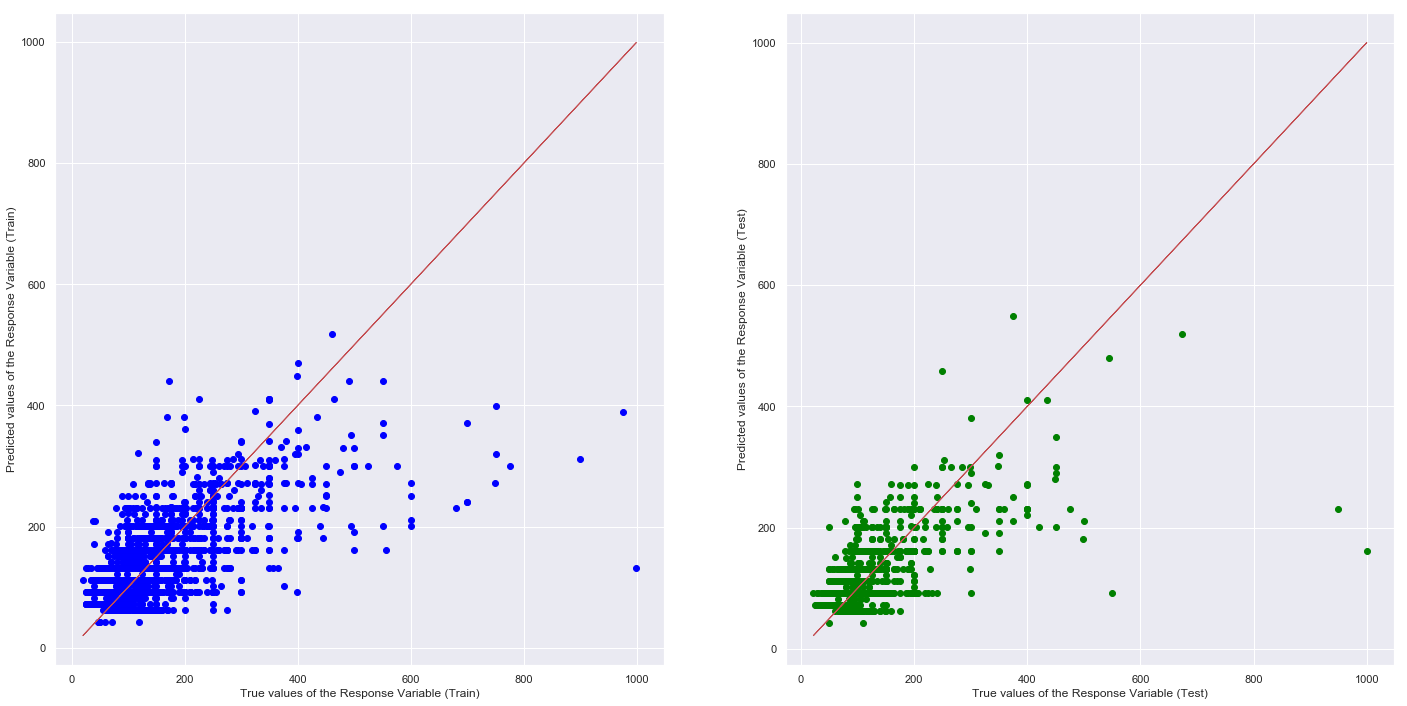

In [214]:
# Predict Response corresponding to Predictors
price_train_pred = linreg.predict(X_train)
price_test_pred = linreg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(Y_train, price_train_pred, color = "blue")
axes[0].plot(Y_train, Y_train, 'w-', linewidth = 1, color = 'r')
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(Y_test, price_test_pred, color = "green")
axes[1].plot(Y_test, Y_test, 'w-', linewidth = 1, color = 'r')
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()




In [233]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer

In [223]:
X = listings[['accommodates', 'bedrooms', 'beds']]
listings.columns.get_loc("price")

57

In [295]:
array = listings.values

col_idx = np.array([50, 52, 53, 57])
data = array[:, col_idx]

In [317]:
data = data.astype(float)

In [337]:
data = data[~np.isnan(data).any(axis=1)]

In [341]:
scaler = Normalizer().fit(data)
normalizedData = scaler.transform(data)

In [348]:

X = normalizedData[:2000,:3]
Y = normalizedData[:2000,3]
kfold = KFold(n_splits=10,random_state=7)
model = LinearRegression()

In [349]:

result = cross_val_score(model,X,Y,cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: -2183606.180% (1234368.785%)


In [257]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

In [326]:
def baseline_model():
# create model
    model = Sequential()
    model.add(Dense(3, input_dim=3, activation='relu')) 
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam') 
    return model

In [327]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=10, batch_size=5, verbose=0)

In [329]:
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Baseline: -21836.06 (12343.69) MSE


In [215]:
# Mean Squared Error (MSE)
def mean_squared_error(actual, predicted):
    '''Returns the Mean Squared Error of actual and predicted values'''
    return np.mean(np.square(np.array(actual) - np.array(predicted)))



# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, Y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(Y_train, price_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, Y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(Y_test, price_test_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.47265993214644864
Mean Squared Error (MSE) 	: 4320.416119810561

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.4337057264279427
Mean Squared Error (MSE) 	: 4517.968723520009

